# `Amazon_Reviews_Classification.ipynb`
[description]

## 1. Introduction
**Purpose** 
- Briefly restate the project objective: we aim to apply various ML models (binary, multiclass classification, and clustering) to the Amazon product reviews dataset.
- Summarize the **dataset** (Training.csv & Test.csv) and the primary challenges (text-based features, multiple tasks, hyperparameter tuning, etc.).
- Mention that all code uses **Python** and **scikit-learn**.

**Notebook Outline**
1. [**Data Loading & Exploration**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
2. [**Preprocessing & Feature Engineering**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
3. [**Binary Classification Tasks**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - Cutoffs 1, 2, 3, 4
    - At least three classifiers, cross-validation, hyperparameter tuning
4. [**Multiclass Classification**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - Five-class (1–5) rating predictions
    - At least three classifiers, cross-validation, hyperparameter tuning
5. [**Clustering**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
    - K-Means on Test.csv reviews
    - Evaluate Silhouette & Rand index
6. [**Kaggle Submission & Results**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)
7. [**Conclusion & Future Work**](https://www.notion.so/Report-Template-1aaeadb7f1c1803a867ff1ffefe4a6d3?pvs=21)

## Data Loading & Exploration
**Objectives**
- Load `Training.csv` and `Test.csv`.
- Basic checks: shapes, missing values, distribution of `overall` ratings, categories, etc.

### Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, f1_score, accuracy_score
)

### Data Loading

In [2]:
# Load the data
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Test.csv")

# Check basic info
print("Training Shape:", df_train.shape)
print("Test Shape:", df_test.shape)
df_train.head()

Training Shape: (29189, 13)
Test Shape: (4500, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive
2,1,True,"09 17, 2014",74A9FA5A64449BEE2A2E8E3F62872F0F,A0E45600FF2C5A779CB4314F379C253A,C6E4DD5C1C4EC09E90182644ED6CA9EF,this wire set it really sucks!!!,One Star,1410912000,NaN,NaN,NaN,automotive
3,1,True,"06 11, 2016",EB561158A2829D98B467FE03CC1E45F1,37AB9A82470595E0ACB88BAC48C150EE,F4892A77EA45C52F40AB17ED537EF9FF,"first use, it leaked instantly. even at 5 buck...",One Star,1465603200,NaN,NaN,"{'Color:': ' Clear', 'Style:': ' 45 Degree'}",automotive
4,1,True,"12 23, 2017",5045D801332850D21618DD13A697CD9B,5772FF30428EEB8E0258C1A53CA2EC50,522F0BBFF2B47F1D63FF781A0AB1D079,didn't fit,One Star,1513987200,NaN,NaN,NaN,automotive


### Quick Exploratory Analysis
1. Check for missing values, duplicates, rating distribution
2. Plot a histogram of `overall` to see rating imbalance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29189 entries, 0 to 29188
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         29189 non-null  int64  
 1   verified        29189 non-null  bool   
 2   reviewTime      29189 non-null  object 
 3   reviewerID      29189 non-null  object 
 4   asin            29189 non-null  object 
 5   reviewerName    29185 non-null  object 
 6   reviewText      29189 non-null  object 
 7   summary         29183 non-null  object 
 8   unixReviewTime  29189 non-null  int64  
 9   vote            6047 non-null   float64
 10  image           600 non-null    object 
 11  style           15365 non-null  object 
 12  category        29189 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 2.7+ MB


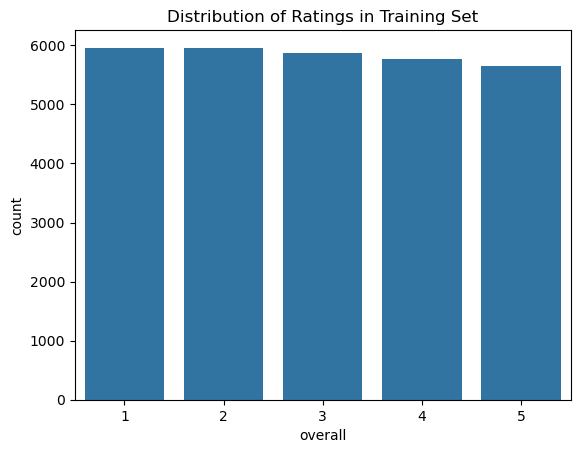

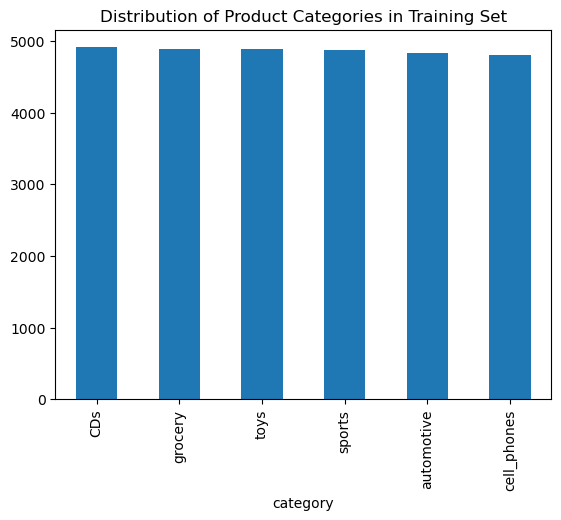

In [3]:
df_train.info()
df_train.isnull().sum()

sns.countplot(data=df_train, x="overall")
plt.title("Distribution of Ratings in Training Set")
plt.show()

# see distribution of categories
df_train["category"].value_counts().plot(kind="bar")
plt.title("Distribution of Product Categories in Training Set")
plt.show()

## 2. Text Preprocessing & Feature Engineering
**Purpose**:
- Convert reviewText into numerical features (e.g. TF-IDF, CountVectorizer)
- (Optional, potentially later) Add metadata features (like verified, vote, text length) to the pipeline
- (Optional, potentially later) Possibly incorporate ngrams or custom text cleaning.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Function to compute length of text review
def extract_length(text_series):
    return pd.DataFrame({"review_length": text_series.apply(len)})

# Extract text features with TF-IDF (Term Frequency - Inverse Document Frequency), later used in column transformer
text_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),  # (1,2) includes unigrams + bigrams
    max_features=10000, # limit feature space
    stop_words='english' # removes common words like "the", "is", "and"
)

length_transformer = FunctionTransformer(extract_length, validate=False)

# Create column transformer to combine text + numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("text_tfidf", text_vectorizer, "reviewText"), # apply TF-IDF to review text column
        ("length", length_transformer, "reviewText"),  # uses same col to get length
        # maybe later add more numeric columns like "vote"
        # ("vote_col", 'passthrough', "vote")
    ],
    remainder="drop"
)

# Pipeline using the preprocessor
from sklearn.linear_model import LogisticRegression
pipe_example = Pipeline([
    ("preprocess", preprocessor),
    ("scale_length", StandardScaler(with_mean=False)),  # only relevant to numeric data
    ("clf", LogisticRegression())
])


## 3.1 Binary Classification Tasks
The four binary tasks are each defined by a cutoff $c \in {1,2,3,4}$
- Label = 1 if `overall` > c, else 0

### Creating Binary Labels

In [5]:
for cutoff in [1,2,3,4]:
    new_col = f"binary_label_cutoff_{cutoff}"
    df_train[new_col] = (df_train["overall"] > cutoff).astype(int)

# Print class distribution for cutoff=1
print("Class Distribution for Cutoff=1:")
print(df_train["binary_label_cutoff_1"].value_counts(normalize=True))

# Print class distribution for cutoff=2
print("\nClass Distribution for Cutoff=2:")
print(df_train["binary_label_cutoff_2"].value_counts(normalize=True))

# Print class distribution for cutoff=3
print("\nClass Distribution for Cutoff=3:")
print(df_train["binary_label_cutoff_3"].value_counts(normalize=True))

# Print class distribution for cutoff=4
print("\nClass Distribution for Cutoff=4:")
print(df_train["binary_label_cutoff_4"].value_counts(normalize=True))



Class Distribution for Cutoff=1:
binary_label_cutoff_1
1    0.795916
0    0.204084
Name: proportion, dtype: float64

Class Distribution for Cutoff=2:
binary_label_cutoff_2
1    0.591764
0    0.408236
Name: proportion, dtype: float64

Class Distribution for Cutoff=3:
binary_label_cutoff_3
0    0.609065
1    0.390935
Name: proportion, dtype: float64

Class Distribution for Cutoff=4:
binary_label_cutoff_4
0    0.806708
1    0.193292
Name: proportion, dtype: float64


### Training & Cross-Validation
- Select a classifer, logistic regression as baseline
- Define parameter grid for both text vectorizer + classifier hyperparams
- Use 5-fold CV with a metric of `f1_macro`

#### Tune `ngram_range`, `C`, and `max_features`

In [6]:
# # Set the final best parameters directly
# final_params = {
#     "preprocess__text_tfidf__ngram_range": (1, 2),
#     "preprocess__text_tfidf__max_features": 500,
#     "clf__solver": "liblinear",
#     "clf__penalty": "l1",
#     "clf__max_iter": 2000,
#     "clf__C": 0.1
# }

# # Apply the best parameters to the pipeline
# pipe_example.set_params(**final_params)

# # Fit the model on the full training data
# pipe_example.fit(df_train[["reviewText"]], df_train["binary_label_cutoff_1"])

# # Print confirmation message
# print("Model trained with best parameters and ready for evaluation.")


### Evaluating the Best Model & Repeating
- Retreiving the best pipeline found via `grid.best_estimator_`
- Generating confusion matrix, ROC curve, AUC, accuracy, macro F1, etc.

In [19]:
# Import necessary libraries
import os
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score


# Use the best parameters found in 3.2
final_pipeline = Pipeline([
    ("preprocess", TfidfVectorizer(
        ngram_range=(1,2),  
        max_features=10000,
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=1,
        max_iter=2000,
        class_weight="balanced"
    ))
])

# Train final model
final_pipeline.fit(df_train["reviewText"], df_train["binary_label_cutoff_1"])

# Generate predictions on training set for evaluation
y_pred_c1 = final_pipeline.predict(df_train["reviewText"])
y_proba_c1 = final_pipeline.predict_proba(df_train["reviewText"])[:,1]

# Evaluation metrics
cm = confusion_matrix(df_train["binary_label_cutoff_1"], y_pred_c1)
print("Confusion Matrix:\n", cm)

print("Macro F1:", f1_score(df_train["binary_label_cutoff_1"], y_pred_c1, average='macro'))
print("Accuracy:", accuracy_score(df_train["binary_label_cutoff_1"], y_pred_c1))

roc_auc = roc_auc_score(df_train["binary_label_cutoff_1"], y_proba_c1)
print("ROC AUC:", roc_auc)

# Generate predictions for Kaggle submission
y_test_pred = final_pipeline.predict(df_test["reviewText"])
df_test["binary_split_1"] = y_test_pred

# make sure results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)  

# make sure 'id' column is index of df_test
df_test["id"] = df_test.index 

# Find existing versions and determine new version number (thanks ChatGPT)
base_filename = "submission_cutoff1"
existing_files = [f for f in os.listdir(results_dir) if re.match(f"{base_filename}_v\d+\.csv", f)]
existing_versions = [int(re.search(r'_v(\d+)\.csv', f).group(1)) for f in existing_files if re.search(r'_v(\d+)\.csv', f)]
new_version = max(existing_versions, default=0) + 1

# new file path
submission_path = os.path.join(results_dir, f"{base_filename}_v{new_version}.csv")

# save only 'id' and 'binary_split_1' columns
df_test[["id", "binary_split_1"]].to_csv(submission_path, index=False)

print(f"Submission file for Kaggle saved: {submission_path} 🚀")


Confusion Matrix:
 [[ 5248   709]
 [ 3586 19646]]
Macro F1: 0.805541080113042
Accuracy: 0.8528555277673096
ROC AUC: 0.9292569038739987
Submission file for Kaggle saved: results/submission_cutoff1_v3.csv 🚀
